# Flooding stage 2 basin evolution - Eastern Mediterranean (eMed)

#### Here we compute the evolution of the mixing depth, mixed-layer salinity and density during the of eMed flooding.

Same concepts in wMed stage 1 basin evolution are used here.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import math
import gsw


## Upload data files here

In [6]:
KE          = np.loadtxt(fname="eMed_flow_KE.txt")
BPEad_eMed  = np.loadtxt(fname="eMed_added_BPE.txt")
SLrise_eMed = np.loadtxt(fname="SLrise_eMed.txt")
Discharge   = np.loadtxt(fname="Discharge.txt")
outD        = np.loadtxt(fname="wMed_outflow_density.txt") 
outS        = np.loadtxt(fname="wMed_outflow_salinity.txt") 
Sprofile_wMed   = np.loadtxt(fname="wMed_SprofileStage3-20.txt") 
Hypsometry_eMed = np.loadtxt(fname="Hypsometry_eMed_evolution.txt")

## Setting parameters

(1027, 1120)

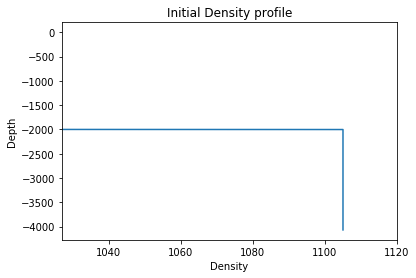

In [7]:

rho_SW   = 1027   # Inflowing sea-water density [kg m^-3]
S_Marine = 36.5   # Atlantic water salinity [PSU]
T_Brine  = 20     # Brine temperature [degrees Celcius]
g        = 9.81   # Acceleration due to gravity [m s^-2]
Mix_Ef   = 0.2    # Mixing efficiency

dzArray = np.linspace(0.5,4070.5,4071)  # Creates an array of mid-layer depths

SWMedlist = Sprofile_wMed.tolist()

for n in range (len(SWMedlist),4071):  # Making the array length of wMed salinity profile similar to eMed profile
    SWMedlist.append(0)                # Necessary to be done to run the script


D_Brine = gsw.density.rho_t_exact ([140],[T_Brine],[0])  # Brine density [kg m^-3]



Depth = Hypsometry_eMed[:,0]
DepthList = Depth.tolist()

Density=np.where(Depth<2001,0,D_Brine)
Salinity=np.where(Depth<2001,0,140.0)
ds = Density.tolist()

Area =(Hypsometry_eMed[:,1])*10**12
Vol_eMed = (Hypsometry_eMed[:,3])*10**12    # Gives the cumulative volume in eMed from present surface towards bottom
Volfrombot = (Hypsometry_eMed[:,2])*10**12 # Gives the cumulative volume in eMed from present bottom towards surface

plt.figure()
plt.title('Initial Density profile')
plt.ylabel('Depth')
plt.xlabel('Density')
plt.plot(Density,-Depth)
plt.xlim([rho_SW,1120])

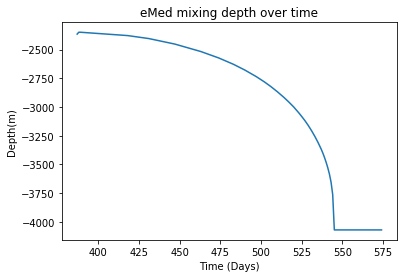

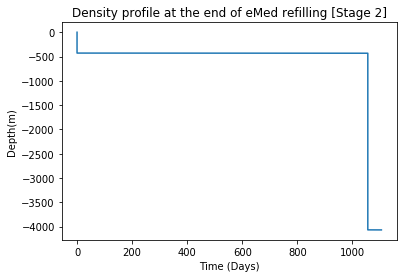

In [10]:
t = 387    # Starting time  
SLtruncated_eMed = np.trunc(SLrise_eMed) 
KEAv = KE*Mix_Ef

SLArray     = [2000]       # initial eMed level
MixedD_eMed = [D_Brine]    # Initial mixied layer density (No mixed layer at the beginning, only the brine)
MixedS_eMed = [140]        # Initial mixied layer salinity (No mixed layer at the beginning)
Mdepth_eMed = []           # Appends daily mixing depth [m]
Times       = []           # Appends time [days]
D_profile   = []           # Appends final density profile at the end of stage 1
S_profile   = []           # Appends final salinity profile at the end of stage 1

Density=np.where(Depth<2001,0,D_Brine)  # Initial density profile of eMed
Salinity=np.where(Depth<2001,0,140.0)   # Initial salinity profile of eMed
# eMed basin is considered to be 4070 m deep, composed of 4070 1 m thick layers

while t<575:
    
    rho_inflow = outD[t-386]  # eMed daily inflow density
    S_inflow = outS[t-386]    # eMed daily inflow salinity
    
    empty_VoleMed = Vol_eMed[(int(SLtruncated_eMed[t-387]))] # empty_VoleMed is the cumulative volume of the empty space above basin surface,
                                                           # as it rises due to inflowing sea water

    SLeMed  = SLrise_eMed[t-386]             # True sea level  (Daily sea level) of the PREVIOUS day
    SLArray.append(SLeMed)
    SLteMed = int(SLtruncated_eMed[t-386])   # Truncated sea level at a given time

    AddedBPE_daily = BPEad_eMed[t-387]       # Total BPE of the daily added sea water layer
    Dis_daily = Discharge[t+2]*3600*24       # Daily discharge
    
    #print (AddedBPE_daily, SLeMed, (SLteMed+1))
    
    dH_eMed = (SLteMed+1)-(SLArray[-1])     # thickness of water layer in the top incompletely-filled layer
    Area_dH = (Area[SLteMed])               # area of the top incompletely-filled layer
    Vol_dH = dH_eMed*Area_dH                # Volume of fluids in top incompletely-filled layer
    
    # Emptying all the arrays in the loop to keep the script running
    
    MixD_eMed = []
    Product_AreaHt = []
    Volarray = []
    BPEMix = []
    BPE_perCell = []
    delta_BPE = []
    Depth_List = []
    Mixed_DList = []
    MixingDepth_eMed = []
    BPE_mixed = []
    D_MixedLayer = []
    index_a = []
    index_b = []
    DenVolw = []
    DenVolTw = []
    BPEi_TotaleMed = []
    BPE_Top = []
    Sal_Vol = []
    SalVol_cumulative = []
    Mixed_Sal = []
    Mixed_D = []
    
    # Following 4 lines calculate the initial BPE profile (Cumulative)

    BPE_perCell = -(Area*Density*g*(Depth-(SLeMed-0.5))) # Initial BPE of completely filled layers
    
    BPE_cumulative = np.cumsum(BPE_perCell)              # cumulative of initial BPE at each layer downwards
    
    BPE_Top = ((dH_eMed/2)**2)*(Area_dH)*(MixedD_eMed[-1])*g  # BPE of the top incompletely filled layer
    
    BPEi_TotaleMed = np.where(BPE_cumulative!=0.0,BPE_cumulative + AddedBPE_daily + BPE_Top,0.0)
    
    # Following 9 lines calculate the BPE after mixing (Cumulative)
    
    Sal_Vol = np.where(Salinity!=0, (Salinity*(Area)),0)  # Computes total salt content of each layer
    SalVol_cumulative = np.cumsum(Sal_Vol)

    # Computes possible mixed salinity during progressive downward mixing at each layer
    Mixed_Sal = np.where(Salinity!=0,((Dis_daily*S_inflow) + SalVol_cumulative +(Vol_dH*(MixedS_eMed[-1])))/(Dis_daily + (Vol_eMed - empty_VoleMed)+Vol_dH),0.0)
    
    Mixed_Sal = Mixed_Sal.tolist()
    
    # Converts salinity to density using GSW Function
    Mixed_D = np.where(Salinity!=0, (gsw.density.rho_t_exact ([Mixed_Sal],[T_Brine],[0])),0.0)
    
    MixD_eMed = np.array(Mixed_D).flatten()

    # product of layer area and mid-layer depth (see explanation wMed stage 1 basin evolution)
    Product_AreaHt = np.where(MixD_eMed!=0,(dzArray - SLeMed)*Area,0)
    Product_cumulative= np.cumsum(Product_AreaHt)

    BPE_mixed = np.where(MixD_eMed!=0,-(MixD_eMed*(Product_cumulative-Product_cumulative[SLteMed])*g)+(AddedBPE_daily*(MixD_eMed/rho_inflow))+(BPE_Top*(MixD_eMed/rho_inflow)) ,0)

    # dBPE for all possibilities of mixing
    delta_BPE = (np.subtract(BPE_mixed,BPEi_TotaleMed))# PROFILE of the change in BPE at each 1 meter level below surface

    #print (BPEi_TotaleMed)
    #print (delta_BPE)
    
    for i,j,j0 in zip(delta_BPE, Depth, MixD_eMed): # To calculate the mixing depth to the closest upper layer bottom.
        
        if i<(KEAv[t]):
            Depth_List.append(j)
            Mixed_DList.append(j0)
        

    MixingDepth_eMed = np.max(Depth_List)  # Daily mixing depth [m]
    D_MixedLayer = np.max(Mixed_DList)     # Mixed layer density [kg^m-3]
    
    Dindex = np.where(MixD_eMed == D_MixedLayer)
    Dind = (Dindex[0])
    Dind = int(Dind)
    
    S_MixedLayer = Mixed_Sal[Dind]    # Mixed layer salinity
    MixedS_eMed.append(S_MixedLayer)  # For plotting
    MixedD_eMed.append(D_MixedLayer)  # For plotting
    
    #print ('Lower limit of the mixed layer is',MixingDepth_eMed,'meters') 
    #print ('Thickness of the mixed layer is',(MixingDepth_eMed-SLeMed),'meters') 
    #print ('Density of the mixed layer is',D_MixedLayer) 
    #print(KE[t+386])
    #print(dd)

    index_a = DepthList.index(SLteMed+1)
    
    if MixingDepth_eMed == 4070:
        index_b = DepthList.index(MixingDepth_eMed)
    else:
        index_b = DepthList.index(MixingDepth_eMed+1)
    
    # Updating the density and salinity profiles after mixing 
    Density2 = Density
    Density2[index_a:index_b]=D_MixedLayer
    
    Density = Density2
    #ddd = Density.tolist()
    #print (t,SLeMed)
    #print (ddd)
    Salinity2 = Salinity
    Salinity2[index_a:index_b]=S_MixedLayer
    
    Salinity = Salinity2
    Mdepth_eMed.append(-MixingDepth_eMed)  
    Times.append(t)
    t=t+1  # Moving in to the next day
    
    if t%100 == 13:   # Use this to save salinity profile at 100-day intervals
        
        filename = 'Profile_%06d.txt'%t
        #print('NOW',filename)
        #np.savetxt(filename,Salinity,fmt="%s")
  
D_profile.append(Density)  
S_profile.append(Salinity)

Dprofile_final = Density.tolist()
Sprofile_final = Salinity.tolist()


Sal10m = []
Dep10m = []

# Creating final salinity profile above Sicily sill, every 40 meters (Used in the EVOLVING MODE)
for i,ii,iii in zip(Sprofile_final,DepthList,SWMedlist):
    
    if ii>0 and ii<4001:
        
        if ii<430:
    
            indexS = DepthList.index(ii)
            #print(indexS, i)
            if (indexS%40) == 0:
        
                Sal10m.append(iii)
                Dep10m.append(ii)
        else:
            
            indexS = DepthList.index(ii)
            #print(indexS, i)

            if (indexS%40) == 0:
        
                Sal10m.append(i)
                Dep10m.append(ii)
        
#print (Sal10m)
        
#np.savetxt("eMed_DprofileStage2-20.txt", np.array(Dprofile_final), fmt="%s")        
#np.savetxt("eMed_SprofileStage2-20E.txt", np.array(Sprofile_final), fmt="%s")
#np.savetxt("eMed MdepthStage2-20E.txt", np.array(Mdepth_eMed), fmt="%s")
#np.savetxt("eMed Salinity with time.txt", np.array(MixedS_eMed))

np.savetxt("Salinity_prof_EPhase.txt", np.array(Sal10m))
#np.savetxt("Depth10m20.txt", np.array(Dep10m))



plt.figure()
plt.title ('eMed mixing depth over time')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Times,Mdepth_eMed)
plt.figure()
plt.title ('Density profile at the end of eMed refilling [Stage 2]')
plt.xlabel('Time (Days)')
plt.ylabel('Depth(m)')
plt.plot(Density,-(Depth))